# la Resting ECG de la clase dos es bernoulli! y la estamos tratando como multinomial

# Es mejor que cada una tenga su distribucion

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm, bernoulli, multinomial, gaussian_kde, shapiro, kstest, poisson
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn import metrics

from sklearn.metrics import classification_report

In [2]:
cleavland = pd.read_csv('05-heart+disease/processed.cleveland.data', header=None, encoding='ISO-8859-1')
hungary = pd.read_csv('05-heart+disease/processed.hungarian.data', header=None, encoding='ISO-8859-1')
switzerland = pd.read_csv('05-heart+disease/processed.switzerland.data', header=None, encoding='ISO-8859-1')
va = pd.read_csv('05-heart+disease/processed.va.data', header=None, encoding='ISO-8859-1')

In [3]:
attributes = ["Age", "Sex", "Chest Pain Type", "Resting Blood Pressure", "Cholesterol", "Fasting Blood Sugar", "Resting ECG", "Max Heart Rate", "Exercise Induced Angina", "ST Depression", "Slope", "Number of Major Vessels", "Thal", "Diagnosis of Heart Disease"]

cleavland.columns = attributes
hungary.columns = attributes
switzerland.columns = attributes
va.columns = attributes

In [4]:
df = pd.concat([cleavland, hungary, switzerland, va], ignore_index=True)

In [5]:
df.replace("?", np.nan, inplace=True)
df.dropna(inplace=True)
df = df.apply(pd.to_numeric)

In [6]:
distributions = {
    'Age': 'continua',
    'Sex': 'categorica',
    'Chest Pain Type': 'entera', 
    'Resting Blood Pressure': 'continua',
    'Cholesterol': 'continua',
    'Fasting Blood Sugar': 'categorica', 
    'Resting ECG': 'categorica',
    'Max Heart Rate': 'continua',
    'Exercise Induced Angina': 'categorica',
    'ST Depression': 'continua',
    'Slope': 'categorica',
    'Number of Major Vessels': 'categorica', 
    'Thal': 'categorica', 
    'Diagnosis of Heart Disease': 'categorica'
}

In [7]:
def probability_categorical(attribute, value, Iwi):
    exitoIwi = len(Iwi[Iwi[attribute] == value])
    nIwi = len(Iwi)
    p = exitoIwi/nIwi
    return p

In [8]:
def fit(train, test, dictionary_of_distributions, esnormal=False):

    classes = test.unique()
    total = len(df)                   # N

    attributes = train.columns           # X_i i \in {1, 2, ...}

    Iwi = []        # Table of instances for each class
    pwi = []        # a priori probability
    pxjIwi = []     # p(X_j|w_i) for each class

    for i in range(len(classes)):                   # For every class

        # Las probabilidades a priori de cada clase en Y. Es decir, P(Y=y_i)

        Iwi.append(df[df[test.name] == classes[i]]) # Iwi (given wi)
        pwi.append(len(Iwi[i])/total)               # Append the a priori probability
        
        pxjIwi.append([])                           # Append an empty list for the conditional probability - chat


        # Las funciones de masa o densidad de probabilidad condicionales

        for attribute in attributes:        # For every attribute except the last one (target variable)

            # si tiene dos valores es bernoulli
            if dictionary_of_distributions[attribute] == 'categorica':
                if len(Iwi[i][attribute].unique()) == 2:
                    teta = Iwi[i][attribute].mean()
                    un_pxiIwi = bernoulli(teta)            # Create a Bernoulli distribution

            elif dictionary_of_distributions[attribute] == 'entera':
                lambda_ = Iwi[i][attribute].mean()  # Calculate the mean
                un_pxiIwi = poisson(lambda_)            # Create a Poisson distribution

            elif dictionary_of_distributions[attribute] == 'continua':

                if esnormal:
                    xbar = Iwi[i][attribute].mean()
                    s = Iwi[i][attribute].std()
                    un_pxiIwi = norm(xbar, s)             # Create a Normal distribution
                    # replace the value of dictionary_of_distributions[attribute] to 'normal' 
                    dictionary_of_distributions[attribute] = 'normal'
                else:
                    un_pxiIwi = gaussian_kde(Iwi[i][attribute]) # Calculate the probability
                    # replace the value of dictionary_of_distributions[attribute] to 'kde'
                    dictionary_of_distributions[attribute] = 'kde'
            else:
                continue

            pxjIwi[i].append(un_pxiIwi)                    # Append the conditional probability

    return pxjIwi, pwi, Iwi, classes, attributes

In [9]:
train = df.iloc[:, :-1]
test = df.iloc[:, -1]

pxjIwi, pwi, Iwi, classes, attributes = fit(train, test, distributions)

# Print the results
print("Conditional probabilities (pxjIwi):", pxjIwi)
print("A priori probabilities (pwi):", pwi)
print("Instances for each class (Iwi):", Iwi)
print("Classes:", classes)
print("Attributes:", attributes)


Conditional probabilities (pxjIwi): [[<scipy.stats._kde.gaussian_kde object at 0x000002AEF5376060>, <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002AEF5375F70>, <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002AEF53756A0>, <scipy.stats._kde.gaussian_kde object at 0x000002AEF5375910>, <scipy.stats._kde.gaussian_kde object at 0x000002AEF5376840>, <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002AEF5376720>, <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002AEF5376720>, <scipy.stats._kde.gaussian_kde object at 0x000002AEF5376A80>, <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002AEF5376BA0>, <scipy.stats._kde.gaussian_kde object at 0x000002AEF5376DE0>, <scipy.stats._kde.gaussian_kde object at 0x000002AEF5376DE0>, <scipy.stats._kde.gaussian_kde object at 0x000002AEF5376DE0>, <scipy.stats._kde.gaussian_kde object at 0x000002AEF5376DE0>], [<scipy.stats._distn_infrastructure.rv_d

In [10]:
def predict(age, sex, chest_pain_type, resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_ecg, max_heart_rate, exercise_induced_angina, st_depression, slope, number_of_major_vessels, thal):

    Pwis = []

    for clase in range(len(classes)):

        # It depends on the distribution

        Pwi = pwi[clase]

        attributes_values = [age, sex, chest_pain_type, resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_ecg, max_heart_rate, exercise_induced_angina, st_depression, slope, number_of_major_vessels, thal]

        for attribute in range(len(attributes_values)):
            
            if distributions[attributes[attribute]] == 'entera':
                Pwi *= poisson.pmf(attributes_values[attribute], Iwi[clase][attributes[attribute]].mean())

            elif distributions[attributes[attribute]] == 'normal':
                Pwi *= norm.pdf(attributes_values[attribute], Iwi[clase][attributes[attribute]].mean(), Iwi[clase][attributes[attribute]].std())

            elif distributions[attributes[attribute]] == 'kde':
                Pwi *= gaussian_kde(Iwi[clase][attributes[attribute]]).pdf(attributes_values[attribute])

            elif distributions[attributes[attribute]] == 'bernoulli':
                Pwi *= bernoulli.pmf(attributes_values[attribute], Iwi[clase][attributes[attribute]].mean())

            elif distributions[attributes[attribute]] == 'categorica':
                Pwi *= probability_categorical(attributes[attribute], attributes_values[attribute], Iwi[clase])

        Pwis.append(Pwi)

    argmax = np.argmax(Pwis)

    return argmax

In [11]:
# Example usage of the predict function
age = 63
sex = 1
chest_pain_type = 3
resting_blood_pressure = 145
cholesterol = 233
fasting_blood_sugar = 1
resting_ecg = 0
max_heart_rate = 150
exercise_induced_angina = 0
st_depression = 2.3
slope = 0
number_of_major_vessels = 0
thal = 1

predicted_class = predict(age, sex, chest_pain_type, resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_ecg, max_heart_rate, exercise_induced_angina, st_depression, slope, number_of_major_vessels, thal)
print("Predicted class:", predicted_class)


Predicted class: 0


In [12]:
def probar_el_clasificador():
    global classes
    global Iwi

    for clase in range(len(classes)):
        Iwi[clase] = Iwi[clase].sample(frac=1).reset_index(drop=True)   # Shuffle the rows

    minitrain = []
    minitest = []

    for clase in range(len(classes)):   # para que tenga al menos un wi de cada clase
        minitrain.append(Iwi[clase].iloc[:  int(len(Iwi[clase])*0.8), :])   # 80% of the rows
        minitest.append(Iwi[clase].iloc[int(len(Iwi[clase])*0.8):, :])      # 20% of the rows

    traindf = pd.concat(minitrain, ignore_index=True)
    testdf = pd.concat(minitest, ignore_index=True)

    pxjIwi, pwi, Iwi, classes, attributes = fit(train, test, distributions)

    predictions = []

    for i in range(len(testdf)):
        predictpredict = predict(*testdf.iloc[i, :-1])
        predictions.append(predictpredict)

    # add the predictions to the dataframe
    testdf["PREDICT PREDICT"] = predictions

    return testdf

In [ ]:
testdf = probar_el_clasificador()

In [14]:
# True labels
y_true = testdf.iloc[:, -2] 

# Predicted labels
y_pred = testdf.iloc[:, -1]

In [15]:
def matriz_confusion(y_true, y_pred, cmap='Blues', title='Matriz de Confusión', xlabel='Predicciones', ylabel='Verdaderos'):

    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=cmap, ax=ax, colorbar=False)
    # 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'
    
    ax.set_title(title, fontsize=10, fontweight='bold')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    plt.show()

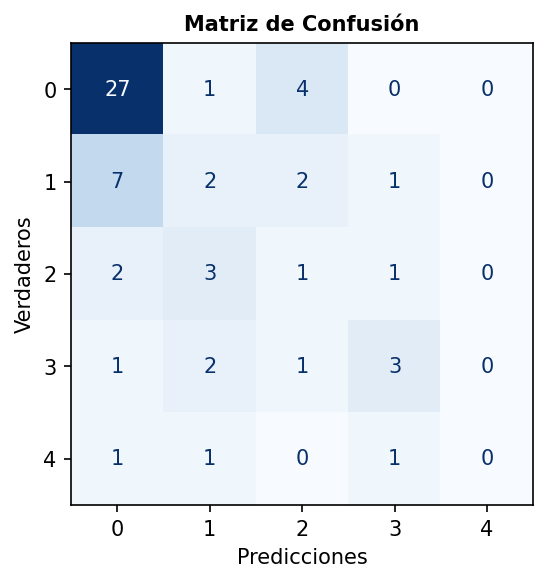

In [16]:
matriz_confusion(y_true, y_pred)

In [17]:
classif_report = classification_report(y_true, y_pred)

c:\Users\herie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\herie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\herie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [18]:
print(classif_report)

              precision    recall  f1-score   support

           0       0.71      0.84      0.77        32
           1       0.22      0.17      0.19        12
           2       0.12      0.14      0.13         7
           3       0.50      0.43      0.46         7
           4       0.00      0.00      0.00         3

    accuracy                           0.54        61
   macro avg       0.31      0.32      0.31        61
weighted avg       0.49      0.54      0.51        61



In [19]:
class bayes_naive:

    def __init__(self, normalokde):

        if normalokde == 'normal':
            self.esnormal = True
        else:
            self.esnormal = False

    def fit(self, train, test, dictionary_of_distributions):
        self.pxjIwi, self.pwi, self.Iwi, self.classes, self.attributes = fit(train, test, dictionary_of_distributions, self.esnormal)

        self.train = train
        self.test = test
        print(test)

    def predict(self, age, sex, chest_pain_type, resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_ecg, max_heart_rate, exercise_induced_angina, st_depression, slope, number_of_major_vessels, thal):
        return predict(age, sex, chest_pain_type, resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_ecg, max_heart_rate, exercise_induced_angina, st_depression, slope, number_of_major_vessels, thal)
    
    def probar_el_clasificador(self):
        testdf = probar_el_clasificador()
        self.testdf = testdf
        return testdf
    
    def confusion_matrix(self, cmap='Blues', title='Matriz de Confusión', xlabel='Predicciones', ylabel='Verdaderos'):
        self.y_pred = self.testdf['PREDICT PREDICT']
        self.y_true = self.testdf[self.test.name]
        return matriz_confusion(self.y_true, self.y_pred, cmap, title, xlabel, ylabel)
    
    def reporte_de_clasificacion(self):
        return print(classification_report(self.y_true, self.y_pred))



In [20]:
train = df.iloc[:, :-1]
test = df.iloc[:, -1]

In [21]:
bn = bayes_naive('normal')
bn.fit(train, test, distributions)

0      0
1      2
2      1
3      0
4      0
      ..
299    2
300    3
301    1
508    1
748    1
Name: Diagnosis of Heart Disease, Length: 299, dtype: int64


In [22]:
bn.predict(age, sex, chest_pain_type, resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_ecg, max_heart_rate, exercise_induced_angina, st_depression, slope, number_of_major_vessels, thal)

0

In [23]:
testdff = bn.probar_el_clasificador()
testdff

,Age,Sex,Chest Pain Type,Resting Blood Pressure,Cholesterol,Fasting Blood Sugar,Resting ECG,Max Heart Rate,Exercise Induced Angina,ST Depression,Slope,Number of Major Vessels,Thal,Diagnosis of Heart Disease,PREDICT PREDICT
0,45.0,1.0,2.0,128.0,308.0,0.0,2.0,170.0,0.0,0.0,1.0,0.0,3.0,0,0
1,57.0,1.0,4.0,132.0,207.0,0.0,0.0,168.0,1.0,0.0,1.0,0.0,7.0,0,0
2,64.0,0.0,3.0,140.0,313.0,0.0,0.0,133.0,0.0,0.2,1.0,0.0,7.0,0,0
3,59.0,1.0,3.0,150.0,212.0,1.0,0.0,157.0,0.0,1.6,1.0,0.0,3.0,0,0
4,60.0,0.0,1.0,150.0,240.0,0.0,0.0,171.0,0.0,0.9,1.0,0.0,3.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,62.0,1.0,2.0,120.0,281.0,0.0,2.0,103.0,0.0,1.4,2.0,1.0,7.0,3,2
57,60.0,0.0,4.0,150.0,258.0,0.0,2.0,157.0,0.0,2.6,2.0,2.0,7.0,3,1
58,63.0,0.0,4.0,150.0,407.0,0.0,2.0,154.0,0.0,4.0,2.0,3.0,7.0,4,4
59,65.0,0.0,4.0,150.0,225.0,0.0,2.0,114.0,0.0,1.0,2.0,3.0,7.0,4,4


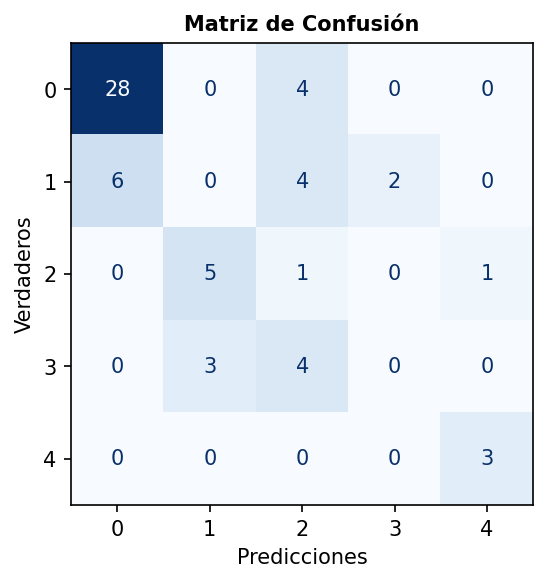

In [26]:
bn.confusion_matrix()

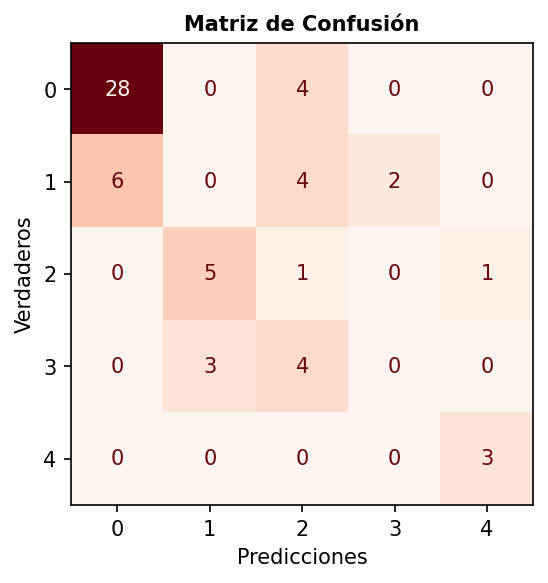

In [27]:
bn.confusion_matrix(cmap='Reds')

In [28]:
bn.reporte_de_clasificacion()

              precision    recall  f1-score   support

           0       0.82      0.88      0.85        32
           1       0.00      0.00      0.00        12
           2       0.08      0.14      0.10         7
           3       0.00      0.00      0.00         7
           4       0.75      1.00      0.86         3

    accuracy                           0.52        61
   macro avg       0.33      0.40      0.36        61
weighted avg       0.48      0.52      0.50        61

